In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:110%;text-align:center;border-radius:200px 10px;">IMAGE CAPTIONING</p>
<br>

<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">Image Captioning is the task of describing the content of an image in words. This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.</span></font>
<br>

<img src="https://raw.githubusercontent.com/danieljl/keras-image-captioning/master/results-without-errors.jpg">



<a id='top'></a>
<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:200%;text-align:center;border-radius:200px 10px;">TABLE OF CONTENTS</p>  

- [1. Imports](#1)
- [2. Hyperparameters](#2)
- [3. Helper Functions](#3)
- [4. Dataset](#4)
  * .[4.1 Feature Extractor and Tokenizer](#4.4)
  * [4.2 Transforms and dataframe](#4.1)
  * [4.3 Dataset Class](#4.2)
  * .[4.4 Train and validation dataset](#4.3)
- [5. Model Building](#5)
    * .[5.1 Model Initialization](#5.2)
- [6. Training](#6)
    * .[6.1 Training Arguments](#6.1)
    * .[6.2 Training using Seq2SeqTrainer](#6.2)
- .[7. Predictions](#7)

In [ ]:
from IPython.display import clear_output
!pip install rouge_score -q
!pip install deep-phonemizer -q
clear_output()

In [ ]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


<a id="2"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">2. HYPERPARAMETERS</p>


In [ ]:
os.environ["WANDB_DISABLED"] = "true"
class config :
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 3
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

<a id="3"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">3. HELPER FUNCTIONS</p>


In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [ ]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


<a id="4.4"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.1 Feature Extractor and Tokenizer : </span></font>


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

<a id="4.1"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.2 Transforms and dataframe : </span></font>


 <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'">The Transformations used are </span></font>
> 1. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"><b>Resizing</b> the image to (224,224) </span></font>
2. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"><b>Normalizing</b> the image</span></font>
3. <font size = 3><span style="color:#3A3E59;font-family:'Times New Roman'"> Converting the image to <b>Tensor</b>  </span></font>

In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5
        )
   ]
)
df=  pd.read_csv("/content/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt").pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding



<a id="4.3"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">4.4 Train and validation dataset: </span></font>


In [ ]:
train_dataset = ImgDataset(train_df, root_dir = "/content/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/content/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

<a id="5"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">5. MODEL BUILDING</p>

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:100%;text-align:center;border-radius:200px 10px;">ENCODER</p>
<br>

<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png">

<br>
<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">The Vision Transformer, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.</span></font>

<p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:100%;text-align:center;border-radius:200px 10px;">DECODER</p>
<br>

<img src = "https://i.stack.imgur.com/7J4O7.png" >

<br>

<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">GPT-2 is a transformers model pretrained on a very large corpus of English data in a self-supervised fashion. inputs are sequences of continuous text of a certain length and the targets are the same sequence, shifted one token (word or piece of word) to the right. The model uses internally a mask-mechanism to make sure the predictions for the token i only uses the inputs from 1 to i but not the future tokens.</span></font>
    
<font size = 3><span style = "color:#3A3E59;font-family:'Times New Roman'">This way, the model learns an inner representation of the English language that can then be used to extract features useful for downstream tasks. The model is best at what it was pretrained for however, which is generating texts from a prompt.</span></font>
    

<a id="5.1"></a>
## <font size = 5><span style="color:#A8642A;font-family:'Times New Roman'">5.1 Model Initialization : </span></font>


In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.10.crossattention.c_attn.weight', 'h.8.crossattention.q_attn.weight', 'h.10.ln_cross_attn.weight', 'h.2.crossattention.c_attn.weight', 'h.9.crossattention.c_proj.bias', 'h.6.ln_cross_attn.weight', 'h.2.ln_cross_attn.weight', 'h.3.crossattention.q_attn.weight', 'h.3.ln_cross_attn.weight', 'h.2.crossattention.q_attn.weight', 'h.2.crossattention.bias', 'h.7.crossattention.bias', 'h.7.crossattention.c_proj.bias', 'h.6.crossattention.q_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.6.crossattention.bias', 'h.3.crossattention.c_attn.weight', 'h.10.crossattention.q_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.10.crossattention.bias', 'h.11.crossattention.q_attn.weight', 'h.0.ln_cross_attn.weight', 'h.4.crossattention.masked_bias', 'h.7.crossattention.c_proj.weight', 'h.9.crossattention.masked_bias', 'h.1.crossattention.c_proj.weight', 'h.8.crossattention.c_attn.weig

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

<a id="6"></a>
# <p style="background-color:#422711;font-family:newtimeroman;color:#F6923D;font-size:140%;text-align:center;border-radius:200px 10px;">6. TRAINING</p>

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    learning_rate = 5e-5,
    #max_steps=1500, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 32364
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12138


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,2.615400,2.395875,0.030200,0.272400,0.052600
2,2.135400,2.225292,0.035100,0.308900,0.061000
3,1.793200,2.205314,0.035900,0.307100,0.062000


Saving model checkpoint to VIT_large_gpt2/checkpoint-2048
Configuration saved in VIT_large_gpt2/checkpoint-2048/config.json
Model weights saved in VIT_large_gpt2/checkpoint-2048/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-2048/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 8091
  Batch size = 8
Saving model checkpoint to VIT_large_gpt2/checkpoint-4096
Configuration saved in VIT_large_gpt2/checkpoint-4096/config.json
Model weights saved in VIT_large_gpt2/checkpoint-4096/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-4096/preprocessor_config.json
Deleting older checkpoint [VIT_large_gpt2/checkpoint-2048] due to args.save_total_limit
Saving model checkpoint to VIT_large_gpt2/checkpoint-6144
Configuration saved in VIT_large_gpt2/checkpoint-6144/config.json
Model weights saved in VIT_large_gpt2/checkpoint-6144/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/checkpoint-6144/preprocessor_config.json
Delet

TrainOutput(global_step=12138, training_loss=2.273365211203967, metrics={'train_runtime': 24050.876, 'train_samples_per_second': 4.037, 'train_steps_per_second': 0.505, 'total_flos': 1.7521600116635468e+19, 'train_loss': 2.273365211203967, 'epoch': 3.0})

In [ ]:
trainer.save_model('VIT_large_gpt2')

Saving model checkpoint to VIT_large_gpt2
Configuration saved in VIT_large_gpt2/config.json
Model weights saved in VIT_large_gpt2/pytorch_model.bin
Feature extractor saved in VIT_large_gpt2/preprocessor_config.json


In [ ]:
import pickle

# Save the tokenizer
with open("/content/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features

    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

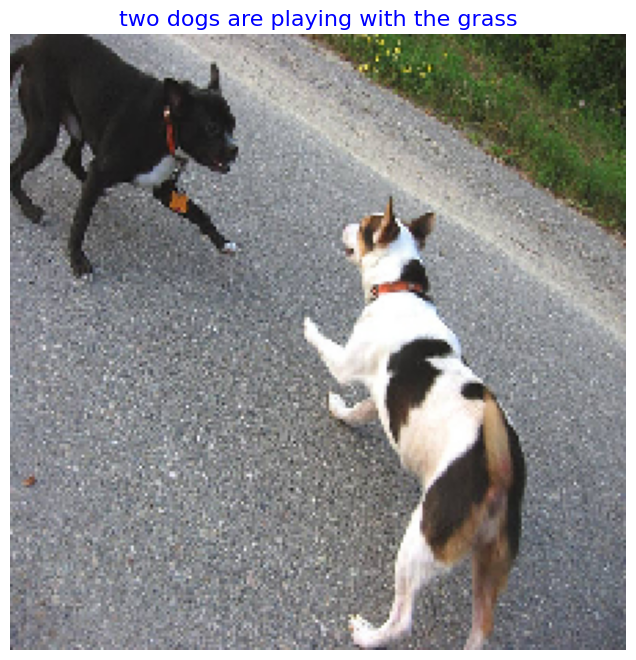

In [ ]:
image_path = "/content/test_img4.png"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

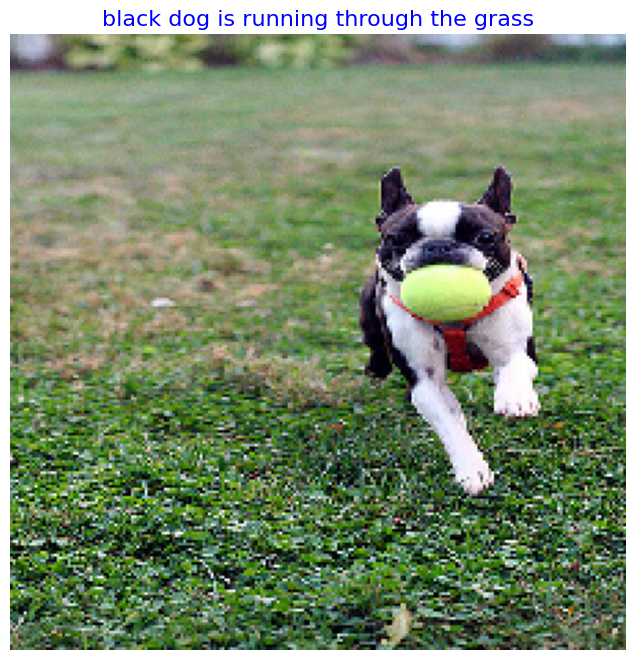

In [ ]:
image_path = "/content/1523984678_edd68464da.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [ ]:
image_path = "/content/1473080948_bae2925dc8.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [ ]:
image_path = "/content/1439046601_cf110a75a7.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [ ]:
image_path = "/content/1130369873_d80a1aa59c.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)